In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import of libraries


In [ ]:
import scipy.io as sio
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as dataloader
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
import random
from random import shuffle
import matplotlib.pyplot as plt
import nibabel as nib
import skimage.transform as skTrans
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Data Preparation

In this section we have NIFTI images of patients' brain.
Before this preparation we split randomically our dataset in two part: train and validation.
Each patient has 91 images of his brain, we decided to resize each image in a 91x91 format, after this we normalize all of them using a min max normalization.
Furthermore we decided to insert all of them in two different lists: one for train and the other one for validation. In addition we created two lists to mantain the patients' id in according to use them to extract ages.

In [ ]:
convert_tensor = transforms.ToTensor()
imgs_data_train = []
ids_train = []
max = 1.2156
#min = 0, calcolato prima sul train (altro file per evitare sovraccarico ram)
for filename in os.listdir('/content/drive/MyDrive/dataset/train'):
  imm = nib.load(os.path.join('/content/drive/MyDrive/dataset/train', filename)).get_fdata()
  result1 = skTrans.resize(imm, (91,91,91), order=1, preserve_range=True)
  imgs_data_train.append(convert_tensor(np.array(result1)/(max)))
  ids_train.append(filename)

In [ ]:
convert_tensor = transforms.ToTensor()
imgs_data_val = []
ids_val = []
for filename in os.listdir('/content/drive/MyDrive/dataset/validation'):
  imm = nib.load(os.path.join('/content/drive/MyDrive/dataset/validation', filename)).get_fdata()
  result1 = skTrans.resize(imm, (91,91,91), order=1, preserve_range=True)
  imgs_data_val.append(convert_tensor(np.array(result1)/(max)))
  ids_val.append(filename)
  #ho tutte le imm con resize e fatta anche la normalizzazione min-max (nb: min è 0, ecco perchè c'è solo max)

the labels about the ages were inside a csv file. we extracted them using the id of the single patient and we decided to append them in two lists one for train one for validation.

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/label_train.csv') #mi serviva estrarre il target (età), una volta aver preso id, immagine ed age li metto insieme in un dataset
ages_train = []

for elem in ids_train:
  l = labels[labels["ID"] == (elem)]
  ages_train.append(l["Age"].values[0])

In [ ]:
ages_val = []

for elem in ids_val:
  l = labels[labels["ID"] == (elem)]
  ages_val.append(l["Age"].values[0])

# Datasets creation

we created a dataset for train and validation. Each of them contains ids, images and the ages named as target.

In [ ]:
#creazione dataset (sempre uno per train e uno per val) (tre campi: id, imm e target (=età))
class MyDataset(Dataset):
  def __init__(self, id, data, target):
    self.id = id
    self.data = data
    self.target = target
  def __getitem__(self, index): #ricevo quando passo l'indice
    x = self.id[index]
    y = self.data[index]
    z = self.target[index]
    return x, y, z
  def __len__(self): #capire la lunghezza (num di righe, cioè num di pazienti) del dataset
    return len(self.target) #basata su target perchè num età = num pazienti

In [ ]:
train_data = MyDataset(ids_train, imgs_data_train, ages_train)
val_data = MyDataset(ids_val, imgs_data_val, ages_val)

# Batch size

we used a batch size of 1 because of limited Ram space of our free version of google colab

In [ ]:
Batch_size = 1
dataloader_train = DataLoader(train_data, batch_size=Batch_size)
dataloader_val = DataLoader(val_data, batch_size=Batch_size)

# Defining a CNN 3d from scratch

In [ ]:
#oltre ad avere i neuroni (nn.Linear), ha livello convoluzione e pooling; (vedere cosa fare nelle rete neurale 3d cosa fa convoluzione e max-pooling)
class CNN(nn.Module):
  def __init__(self, num_classes):
    super(CNN, self).__init__()
    self.conv_layer1 = nn.Conv3d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 2)
    self.conv_layer2 = nn.Conv3d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 2)
    self.conv_layer3 = nn.Conv3d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 2)
    self.conv_layer4 = nn.Conv3d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 2)
    self.max_pool = nn.MaxPool3d((2,2,2))
    self.fc1 = nn.Linear(43904, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, num_classes)
    self.dropout_lyr = nn.Dropout(0,25)

  def forward(self, x):
    x = self.max_pool(F.relu(self.conv_layer1(x)))
    x = self.max_pool(F.relu(self.conv_layer2(x)))
    x = self.max_pool(F.relu(self.conv_layer3(x)))
    x = self.max_pool(F.relu(self.conv_layer4(x)))
    x = x.view(-1,43904)
    x = F.relu(self.fc1(x))
    x = self.dropout_lyr(x)
    x = F.relu(self.fc2(x))
    x = self.dropout_lyr(x)
    x = self.fc3(x)
    return x

# Training

In [ ]:
#addestramento, usato come discesa stocastica del gradiente come optimizer (SGD)
learning_rate = 0.0001
startEpoch = 200
numEpochs = 300
model = CNN(1).cuda()
model.load_state_dict(torch.load('/content/drive/MyDrive/best_model_weights-c4.pth'))
#model.eval()
criterion = nn.L1Loss()
index = 0
best_loss = 5.1212
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for epochs in range(startEpoch,numEpochs + 1):
  modelLoss_train = 0.0
  totalSize = 0
  for _,inputs,target in dataloader_train:
    optimizer.zero_grad()

    #inputs = torch.unsqueeze(train_data.data[0], dim = 0)
    inputs = inputs.type(torch.FloatTensor).requires_grad_().cuda()
    target = target.cuda()
    output = model(inputs)
    #outp,preds = torch.max(output,1)
    loss = criterion(output[0],target)

    modelLoss_train += loss.item()*inputs.size(0)
    totalSize += inputs.size(0)
    #print(preds)
    loss.backward()
    optimizer.step()
    index += 1

  modelLoss_epoch_train = modelLoss_train/totalSize

  #salvataggio stato
  torch.save(model.state_dict(), '/train_weights.pth')
  model.eval()

  totalSize_val = 0
  modelLoss_val = 0.0

  for _,inputs,labels in dataloader_val:
    #inputs = torch.unsqueeze(train_data.data[0], dim = 0)
    inputs = inputs.type(torch.FloatTensor).requires_grad_().cuda()
    labels = labels.cuda()
    y = model(inputs)
    #outp, preds = torch.max(y,1)
    lossCNN = criterion(y[0],labels)

    modelLoss_val += lossCNN.item()*inputs.size(0)
    totalSize_val += inputs.size(0)

  modelLoss_epoch_val = modelLoss_val/totalSize_val
  print('Epoch[%d] Loss_train: %.4f ; Loss: %.4f'%(epochs, modelLoss_epoch_train, modelLoss_epoch_val));

  if(modelLoss_epoch_val < best_loss and modelLoss_epoch_val>modelLoss_epoch_train):
        print('..... Saving best weights ....')
        best_loss = modelLoss_epoch_val
        best_epoca = epochs

        torch.save(model.state_dict(), '/content/drive/MyDrive/best_model_weights-c4.pth')

  with open('/content/drive/MyDrive/TXT-4/lossVal.txt', "a") as file_object:
        file_object.write(str(modelLoss_epoch_val)+ '\n')

  with open('/content/drive/MyDrive/TXT-4/lossTrain.txt', "a") as file_object:
        file_object.write(str(modelLoss_epoch_train)+ '\n')


Epoch[200] Loss_train: 3.5962 ; Loss: 5.2334
Epoch[201] Loss_train: 3.5735 ; Loss: 5.0756
..... Saving best weights ....
Epoch[202] Loss_train: 3.4623 ; Loss: 5.1637
Epoch[203] Loss_train: 3.4005 ; Loss: 5.1265
Epoch[204] Loss_train: 3.3582 ; Loss: 5.1690
Epoch[205] Loss_train: 3.3054 ; Loss: 5.1172
Epoch[206] Loss_train: 3.2850 ; Loss: 5.0306
..... Saving best weights ....
Epoch[207] Loss_train: 3.2207 ; Loss: 5.0339
Epoch[208] Loss_train: 3.1341 ; Loss: 5.4910
Epoch[209] Loss_train: 3.1871 ; Loss: 5.3367
Epoch[210] Loss_train: 3.0999 ; Loss: 5.4532
Epoch[211] Loss_train: 3.0348 ; Loss: 5.2142
Epoch[212] Loss_train: 2.9446 ; Loss: 5.2494
Epoch[213] Loss_train: 2.9328 ; Loss: 5.1170
Epoch[214] Loss_train: 2.8635 ; Loss: 4.9178
..... Saving best weights ....
Epoch[215] Loss_train: 2.8100 ; Loss: 4.7326
..... Saving best weights ....
Epoch[216] Loss_train: 2.8037 ; Loss: 4.7749
Epoch[217] Loss_train: 2.7598 ; Loss: 5.1693
Epoch[218] Loss_train: 2.7508 ; Loss: 5.2300
Epoch[219] Loss_train

# Printing results

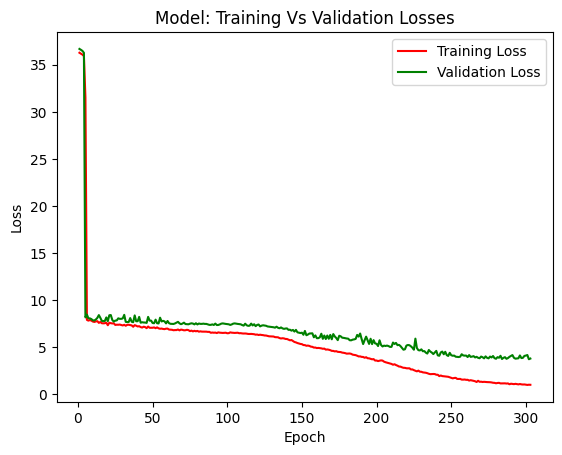

In [ ]:
lossModel_Train = []
lossModel_val = []

WeightPath = '/content/drive/MyDrive/TXT-4/'
file = open(WeightPath + 'lossTrain.txt', 'r')
Testo = file.readlines()
for element in Testo:
  lossModel_Train.append(float(element))
  file = open(WeightPath + 'lossVal.txt', 'r')
  Testo = file.readlines()
for element in Testo:
  lossModel_val.append(float(element))
plt.figure()
plt.title("Model: Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(list(range(1,len(lossModel_Train)+1)), lossModel_Train, color='r', label="Training Loss")
plt.plot(list(range(1, len(lossModel_val)+1)), lossModel_val, color='g', label="Validation Loss")
plt.legend()
plt.savefig(WeightPath + 'LossTrainVal.png')

# Pretreat test

we had other files which didn't have ages. Firstly we pretreat our test as we did for train and validation. Secondly we decided to create a dataset for test

In [ ]:
convert_tensor = transforms.ToTensor()
imgs_data_test = []
ids_test = []
max = 1.2156

for filename in os.listdir('/content/drive/MyDrive/data_test'):
  imm = nib.load(os.path.join('/content/drive/MyDrive/data_test', filename)).get_fdata()
  result1 = skTrans.resize(imm, (91,91,91), order=1, preserve_range=True)
  imgs_data_test.append(convert_tensor(np.array(result1)/(max)))
  ids_test.append(filename)

In [ ]:
class MyDataTest(Dataset):
  def __init__(self, id, data):
    self.id = id
    self.data = data
  def __getitem__(self, index): #ricevo quando passo l'indice
    x = self.id[index]
    y = self.data[index]
    return x, y
  def __len__(self): #capire la lunghezza (num di righe, cioè num di pazienti) del dataset
    return len(self.id) #basata su target perchè num età = num pazienti

In [ ]:
test_data = MyDataTest(ids_test, imgs_data_test)

Batch_size = 1
dataloader_test = DataLoader(test_data, batch_size=Batch_size)

# Loading weights

In [ ]:
model = CNN(1)
model.load_state_dict(torch.load('/content/drive/MyDrive/best_model_weights-out00001-2.pth', map_location ='cpu'))

<All keys matched successfully>

# Extracting ages for test

In [ ]:
Test = pd.DataFrame()
for id, input in dataloader_test:
  print('Working on '+ str(id))
  input = input.type(torch.FloatTensor).requires_grad_()
  y = model(input)
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)

Working on ('rrssmrSub_0342_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0342_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0343_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0342_v04_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0342_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0343_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0342_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0347_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0350_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0348_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0349_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0345_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0349_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0343_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0351_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0346_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0348_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0350_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0344_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0351_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0352_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0353_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0352_v05_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0353_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0352_v04_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0353_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0352_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0353_v04_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0352_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0352_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0351_v04_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0351_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0353_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0352_v06_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0352_v07_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0351_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0356_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0359_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0355_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0355_v04_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0360_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0359_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0355_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0355_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0358_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0357_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0358_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0354_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0356_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0356_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0356_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0355_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0370_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0368_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0367_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0363_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0369_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0361_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0363_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0366_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0362_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0364_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0363_v05_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0363_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0362_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0362_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0365_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0363_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0363_v04_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0371_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0372_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0376_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0371_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0376_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0373_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0376_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0376_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0372_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0370_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0373_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0377_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0375_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0378_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0378_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0374_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0378_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0382_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0379_v04_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0379_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0381_v05_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0381_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0379_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0378_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0381_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0381_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0381_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0379_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0379_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0381_v04_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0383_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0378_v04_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0380_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0386_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0385_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0383_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0384_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0387_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0386_v04_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0386_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0386_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0386_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0389_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0389_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0389_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0388_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0390_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0390_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0390_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0391_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0391_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0390_v04_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0390_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0392_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0392_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0392_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0391_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0393_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0392_v04_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0392_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0396_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0395_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0394_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0394_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0398_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0398_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0397_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0397_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0398_v04_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0398_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0398_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0399_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0399_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0399_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0401_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0401_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0400_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0399_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0402_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0401_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0401_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0404_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0403_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0403_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0402_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0406_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0405_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0405_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0406_v04_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0406_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0406_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0406_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0409_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0408_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0407_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0409_v04_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0409_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0409_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0409_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0410_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0410_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0409_v05_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0411_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0410_v04_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0410_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0410_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0413_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0413_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0412_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0416_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0415_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0414_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0414_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0416_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0416_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0416_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0419_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0418_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0417_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0416_v04_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0421_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0420_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0419_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0419_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0421_v04_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0421_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0421_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0421_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0423_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0423_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0422_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0424_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0423_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0423_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0425_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0425_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0425_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0425_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0426_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0426_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0426_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0425_v04_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0427_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0427_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0426_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0428_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0428_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0427_v03_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0427_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0429_v02_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0429_v01_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


Working on ('rrssmrSub_0429_v00_T1.nii',)


<ipython-input-9-39b1b04a5fb3>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test = Test.append({'ID': id, 'Age': y.item()}, ignore_index = True)


# Creation of an excel and csv files of results

In [ ]:
Test[['ID','Age']].to_excel('/content/drive/MyDrive/Results.xlsx')

In [ ]:
df = pd.read_excel(r'/content/drive/MyDrive/res.xlsx')

In [ ]:
df.to_csv('/content/drive/MyDrive/Results.csv', index = False)